In [10]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, evaluate
from wordcloud import WordCloud, STOPWORDS

import warnings; warnings.simplefilter('ignore')


In [2]:
!pip install surprise


    100% |████████████████████████████████| 2.3MB 430kB/s ta 0:00:01
  Running setup.py bdist_wheel for scikit-surprise ... done
  Stored in directory: /Users/frances/Library/Caches/pip/wheels/72/f4/52/a74e2689f98bed7029e2b3da4ade72024ba0f1975a990e283c
Successfully built scikit-surprise


In [7]:
df = pd.read_csv('/Users/frances/Desktop/tmdb-movie-metadata/movies_metadata.csv')
df.head().transpose()

,0,1,2,3,4
adult,False,False,False,False,False
belongs_to_collection,"{'id': 10194, 'name': 'Toy Story Collection', ...",NaN,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",NaN,"{'id': 96871, 'name': 'Father of the Bride Col..."
budget,30000000,65000000,0,16000000,0
genres,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...","[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...","[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...","[{'id': 35, 'name': 'Comedy'}]"
homepage,http://toystory.disney.com/toy-story,NaN,NaN,NaN,NaN
id,862,8844,15602,31357,11862
imdb_id,tt0114709,tt0113497,tt0113228,tt0114885,tt0113041
original_language,en,en,en,en,en
original_title,Toy Story,Jumanji,Grumpier Old Men,Waiting to Exhale,Father of the Bride Part II
overview,"Led by Woody, Andy's toys live happily in his ...",When siblings Judy and Peter discover an encha...,A family wedding reignites the ancient feud be...,"Cheated on, mistreated and stepped on, the wom...",Just when George Banks has recovered from his ...


In [8]:
df = df.drop(['imdb_id'], axis=1)
df[df['original_title'] != df['title']][['title', 'original_title']].head()
df = df.drop('original_title', axis=1)
df[df['revenue'] == 0].shape
df['revenue'] = df['revenue'].replace(0, np.nan)
df['budget'] = pd.to_numeric(df['budget'], errors='coerce')
df['budget'] = df['budget'].replace(0, np.nan)
df[df['budget'].isnull()].shape
df['return'] = df['revenue'] / df['budget']
df[df['return'].isnull()].shape
df['year'] = pd.to_datetime(df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)
df['adult'].value_counts()
df = df.drop('adult', axis=1)


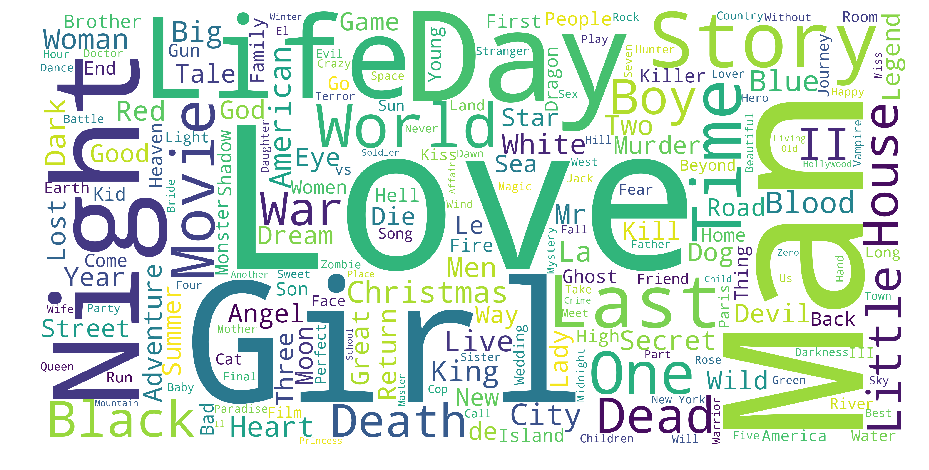

In [11]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')
title_corpus = ' '.join(df['title'])
overview_corpus = ' '.join(df['overview'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [13]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [14]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [15]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [16]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

In [17]:
months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
df_21 = df.copy()
df_21['year'] = df_21[df_21['year'] != 'NaT']['year'].astype(int)
df_21 = df_21[df_21['year'] >=2000]
hmap_21 = pd.pivot_table(data=df_21, index='month', columns='year', aggfunc='count', values='title')
hmap_21 = hmap_21.fillna(0)


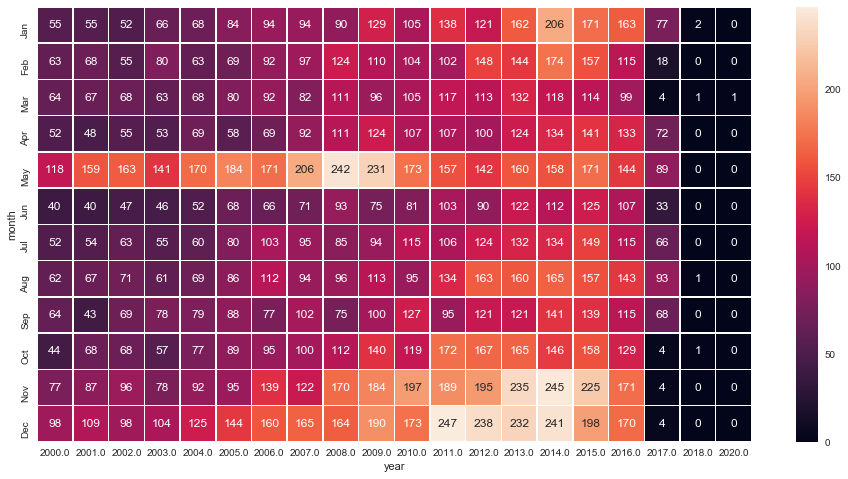

In [18]:
sns.set(font_scale=1)
f, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(hmap_21, annot=True, linewidths=.5, ax=ax, fmt='n', yticklabels=month_order)